In [1]:
import requests
from bs4 import BeautifulSoup
import re
import os
from collections import defaultdict
import networkx
import matplotlib.pyplot as plt
%matplotlib inline

# 爬虫

In [2]:
def visitUrl(url,savePath='D:\\pyproject\\git\\AI-NLP\\data\\BeijingLines\\'):
    r = requests.get(url=url,headers=headers)
    r.encoding = r.apparent_encoding
    soup = BeautifulSoup(r.text,'html.parser')
    # 存储网页
    title = soup.title.string.split('_')[0]
    filename = savePath + title +'.html'
    fp = open(filename,'w',encoding=r.encoding)
    fp.write(r.text)
    fp.close()
    # 找到网页上所有的url 
    urls = []
    for t in soup.find_all('a'):
        url = t.get('href')
        if url and re.search(r'^/item/.*',url):
            urls.append(url)
    return urls

### 学习代码，不运行。（从 '/item/北京地铁/408485' 开始，广度搜索遍历百度百科词条，不需要这样查找车站信息）

In [3]:
# # 从 '/item/北京地铁/408485' 开始，广度搜索遍历百度百科词条
# visited = set()
# needVisit = [('/item/北京地铁/408485',0)]
# maxDepth = 1
# while needVisit:
#     node = needVisit.pop(0)
#     url = node[0]
#     depth = node[1]
#     print (url,depth)
#     if (url in visited) or (depth>maxDepth) : continue
    
#     urls = visitUrl("http://baike.baidu.com"+url,'D:\\pyproject\\git\\AI-NLP\\data\\BeijingSubway\\')
#     visited.add(url)
#     needVisit = needVisit + [(e,depth+1) for e in urls]
        

### 从北京地铁词条的网页里，找到北京地铁XX线的url，访问这些url并存下网页

In [4]:
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko'}
r = requests.get(url=r"https://baike.baidu.com/item/北京地铁/408485",headers=headers)
r.encoding = r.apparent_encoding # 避免显示乱码
soup = BeautifulSoup(r.text,'html.parser')

savePath = 'D:\\pyproject\\git\\AI-NLP\\data\\BeijingLines\\'
urls = []
for t in soup.find_all('a'):
    name = t.string
    url = t.get('href')
    if name and re.search(r'^北京地铁.*线$',name) and (url not in urls):
        urls.append(url)
        print (name)

urls.append('/item/北京地铁机场线/4262277') # 补上机场线
# 访问各线路的百度词条，存网页
for url in urls:
    visitUrl("http://baike.baidu.com"+url,savePath)

北京地铁1号线
北京地铁2号线
北京地铁4号线
北京地铁5号线
北京地铁6号线
北京地铁7号线
北京地铁8号线
北京地铁9号线
北京地铁10号线
北京地铁13号线
北京地铁14号线
北京地铁15号线
北京地铁16号线
北京地铁八通线
北京地铁昌平线
北京地铁亦庄线
北京地铁房山线
北京地铁大兴线


In [ ]:
### 处理存储的北京地铁XX线的html，从首末时间表中抓取车站信息，存在graphSubway，stationsEachLine，linesEachStation结构中

In [5]:
def tokenize(string): 
    return ''.join(re.findall('[\w|\d]+', string))

graphSubway = defaultdict(list)
stationsEachLine = defaultdict(list)
linesEachStation = defaultdict(list)

for filename in os.listdir(savePath):
    print (filename)
    htmlfile = open(savePath+filename, 'r', encoding='utf-8')
    soup = BeautifulSoup(htmlfile.read(),'html.parser')
    htmlfile.close()
    stationNames = []
    lineName = filename.split('.')[0]
    for tb in soup.find_all('table'):
        # 从首末车时间表中提取车站名字
        if not re.search(r'.*首末车.*',tb.get_text()): continue 
        for tr in tb.find_all('tr'):
            row = []
            for td in tr.find_all(re.compile("^t")):
                row.append(tokenize(td.get_text()))
            # 该行只有包含时间数字，第一列才会是车站名
            if re.findall('[\d]{3,}',''.join(row)): 
                stationNames.append(row[0])
                linesEachStation[row[0]].append(lineName)
        stationsEachLine[lineName] = stationNames
        # ps:14号线有两个首末时间表，其他线路假定只有一个时间表。
    # 根据 stationNames添加graph连接
    for i in range(1,len(stationNames)):
        # ps: 1号线和八通线，4号线和大兴线的站点有重合，使得graphSubway会出现重复的连接
        if (stationNames[i] in  graphSubway[stationNames[i-1]]) or  (stationNames[i-1] in  graphSubway[stationNames[i]]):
            print (stationNames[i-1],stationNames[i])
        graphSubway[stationNames[i-1]].append(stationNames[i])
        graphSubway[stationNames[i]].append(stationNames[i-1])


# 2号线、10号线是环线，补齐首尾连接
graphSubway['西直门'].append('车公庄') 
graphSubway['车公庄'].append('西直门') 
graphSubway['巴沟'].append('火器营')
graphSubway['火器营'].append('巴沟')
# 14号线 西局和北京南之间的连接要断开
graphSubway['西局'].remove('北京南站')
graphSubway['北京南站'].remove('西局')
# 机场线错误的记录一个叫“备注”的站
graphSubway['2号航站楼'].remove('备注')
stationsEachLine['北京地铁机场线'].remove('备注')
del linesEachStation['备注']
del graphSubway['备注']
# 机场线车站名“东直门站”和“东直门”合并
for e in graphSubway['东直门站']: graphSubway['东直门'].append(e) 
del graphSubway['东直门站']
del linesEachStation['东直门站']
linesEachStation['东直门'].append('北京地铁机场线')
stationsEachLine['北京地铁机场线'][0] = '东直门'

graphSubway['三元桥'].remove('东直门站')

北京地铁10号线.html
北京地铁13号线.html
北京地铁14号线.html
北京地铁15号线.html
北京地铁16号线.html
北京地铁1号线.html
北京地铁2号线.html
北京地铁4号线.html
北京地铁5号线.html
北京地铁6号线.html
北京地铁7号线.html
北京地铁8号线.html
北京地铁9号线.html
北京地铁亦庄线.html
北京地铁八通线.html
四惠 四惠东
北京地铁大兴线.html
天宫院 生物医药基地
生物医药基地 义和庄
义和庄 黄村火车站
黄村火车站 黄村西大街
黄村西大街 清源路
清源路 枣园
枣园 高米店南
高米店南 高米店北
高米店北 西红门
西红门 新宫
新宫 公益西桥
公益西桥 角门西
角门西 马家堡
马家堡 北京南站
北京南站 陶然亭
陶然亭 菜市口
菜市口 宣武门
宣武门 西单
西单 灵境胡同
灵境胡同 西四
西四 平安里
平安里 新街口
新街口 西直门
西直门 动物园
动物园 国家图书馆
国家图书馆 魏公村
魏公村 人民大学
人民大学 海淀黄庄
海淀黄庄 中关村
中关村 北京大学东门
北京大学东门 圆明园
圆明园 西苑
西苑 北宫门
北京地铁房山线.html
北京地铁昌平线.html
北京地铁机场线.html


### 画图

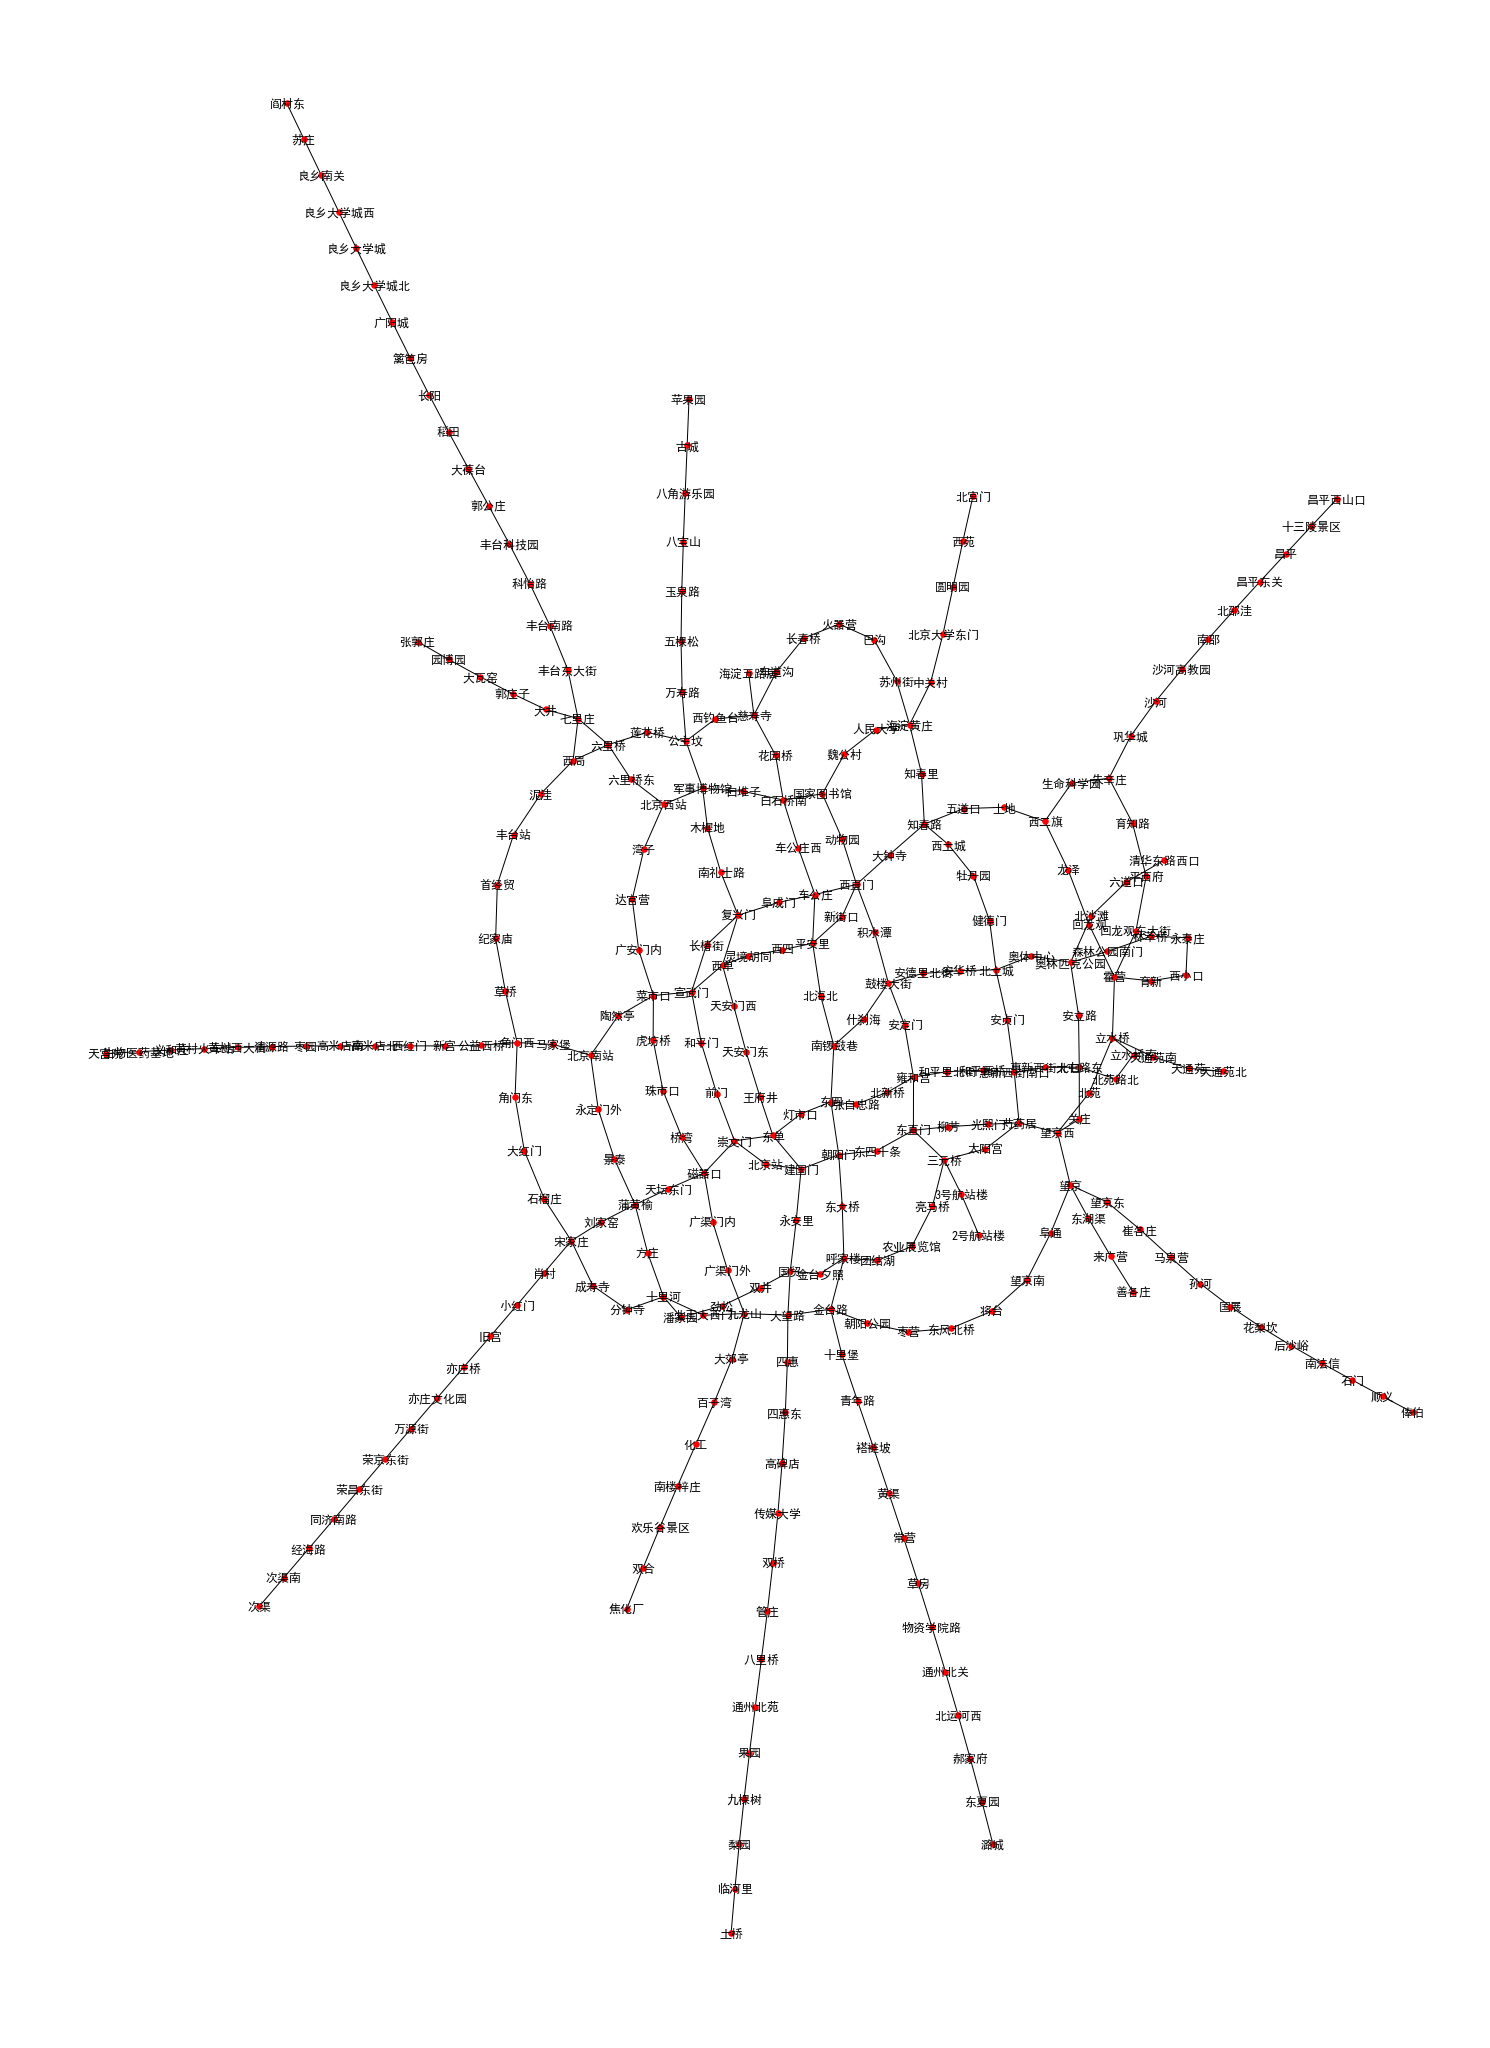

In [6]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'

graphDraw = networkx.Graph(graphSubway)
plt.figure(figsize=(20,28))
networkx.draw_kamada_kawai(graphDraw, with_labels=True,node_size=30)

In [ ]:
import 
def search_djikstra(graph,start):
    frontier = [start]
    explored = set()
    dist = {}
    prev = {}
    dist[start] = 0
    
    while frontier:
        node = frontier.pop(0)
        
        for n in graph[node]:
            if n in explored: continue
            alt = dist[node] + 1.0
        

In [7]:
for e in graphSubway:
    print (e)

巴沟
苏州街
海淀黄庄
知春里
知春路
西土城
牡丹园
健德门
北土城
安贞门
惠新西街南口
芍药居
太阳宫
三元桥
亮马桥
农业展览馆
团结湖
呼家楼
金台夕照
国贸
双井
劲松
潘家园
十里河
分钟寺
成寿寺
宋家庄
石榴庄
大红门
角门东
角门西
草桥
纪家庙
首经贸
丰台站
泥洼
西局
六里桥
莲花桥
公主坟
西钓鱼台
慈寿寺
车道沟
长春桥
火器营
西直门
大钟寺
五道口
上地
西二旗
龙泽
回龙观
霍营
立水桥
北苑
望京西
光熙门
柳芳
东直门
张郭庄
园博园
大瓦窑
郭庄子
大井
七里庄
北京南站
永定门外
景泰
蒲黄榆
方庄
北工大西门
九龙山
大望路
金台路
朝阳公园
枣营
东风北桥
将台
望京南
阜通
望京
东湖渠
来广营
善各庄
俸伯
顺义
石门
南法信
后沙峪
花梨坎
国展
孙河
马泉营
崔各庄
望京东
关庄
大屯路东
安立路
奥林匹克公园
北沙滩
六道口
清华东路西口
苹果园
古城
八角游乐园
八宝山
玉泉路
五棵松
万寿路
军事博物馆
木樨地
南礼士路
复兴门
西单
天安门西
天安门东
王府井
东单
建国门
永安里
四惠
四惠东
积水潭
鼓楼大街
安定门
雍和宫
东四十条
朝阳门
北京站
崇文门
前门
和平门
宣武门
长椿街
阜成门
车公庄
天宫院
生物医药基地
义和庄
黄村火车站
黄村西大街
清源路
枣园
高米店南
高米店北
西红门
新宫
公益西桥
马家堡
陶然亭
菜市口
灵境胡同
西四
平安里
新街口
动物园
国家图书馆
魏公村
人民大学
中关村
北京大学东门
圆明园
西苑
北宫门
刘家窑
天坛东门
磁器口
灯市口
东四
张自忠路
北新桥
和平里北街
和平西桥
惠新西街北口
北苑路北
立水桥南
天通苑南
天通苑
天通苑北
海淀五路居
花园桥
白石桥南
车公庄西
北海北
南锣鼓巷
东大桥
十里堡
青年路
褡裢坡
黄渠
常营
草房
物资学院路
通州北关
北运河西
郝家府
东夏园
潞城
北京西站
湾子
达官营
广安门内
虎坊桥
珠市口
桥湾
广渠门内
广渠门外
大郊亭
百子湾
化工
南楼梓庄
欢乐谷景区
双合
焦化厂
朱辛庄
育知路
平西府
回龙观东大街
育新
西小口
永泰庄
林萃桥
森林公园南门
奥体中心
安华桥
安德里北街
什刹海
郭公庄
丰台科技园
科怡路
丰台南路
丰台东大街
六里桥东
白堆子
肖村
小红门
旧宫
亦庄桥
亦庄文化

In [85]:
def get_succsssors(froninter, graph):
    return graph[froninter]

In [86]:
def is_goal(predicate):
    def _predicate(condition):
        return predicate(condition)
    return _predicate

In [229]:
def is_goal(node, destination): 
    return node ==  desitnation

In [412]:
def search_destination(graph, start, get_succsssors, is_goal_predicate, strategy_func):
    pathes = [[start]]
    seenPathes = set()
    chosen_pathes = []
    while pathes:

        path = pathes.pop(0)
        frontier = path[-1]
        if ''.join(path) in seenPathes: continue
            
        for city in get_succsssors(frontier, graph):
            if city in path: continue # remove the loop
            new_path = path + [city]
            pathes.append(new_path)
            if is_goal_predicate(city): ##return new_path
                chosen_pathes.append(new_path)
        pathes = strategy_func(pathes)
        seenPathes.add(''.join(path))
    return strategy_func(chosen_pathes)

In [413]:
def sort_pathes(pathes, func,beam):
    return sorted(pathes, key=func)[:beam]

In [428]:
def mini_distance(pathes):
    return sort_pathes(pathes, lambda p: len(p), beam=50)

In [429]:
def transfer_info_path(path):  
    if not path: return []
    lineNow = list(set(linesEachStation[path[0]]).intersection(set(linesEachStation[path[1]])))[0]
    transferList = [(path[0],lineNow)]    
    for i in range(2,len(path)):
        if lineNow not in linesEachStation[path[i]]:
            lineNow = list(set(linesEachStation[path[i]]).intersection(set(linesEachStation[path[i-1]])))[0]
            transferList.append((path[i-1],lineNow))
    return transferList
            

In [443]:
def mini_transfer(pathes):
    return sort_pathes(pathes,lambda p:len(transfer_info_path(p))-1,beam=50)

In [444]:
def comprehensive_sort(pathes):
    return sort_pathes(pathes,lambda p:(len(transfer_info_path(p))-1)*3+len(p),beam=50) # 假定换乘一次时间等于坐3个站

In [445]:
def print_path(path):
    transferList = transfer_info_path(path)
    strPath = ''
    strPath = strPath + ('%s --%s-->' % (transferList[0][0],transferList[0][1][4:]))
    for i in range(1,len(transferList)):
        strPath = strPath + (' %s --%s-->' % (transferList[i][0],transferList[i][1][4:]))
    strPath = strPath + (' %s (%s站)' % (path[-1],len(path)-1))
    print (strPath)

def print_top_pathes(pathes,n=5):
    for i in range(len(pathes)):
        if i >= n : break
        print_path(pathes[i])

In [456]:
pathes = search_destination(graphSubway, '苏庄', get_succsssors, lambda n: n == '阜成门', mini_distance)

In [457]:
print_top_pathes(pathes,n=5)

苏庄 --房山线--> 郭公庄 --9号线--> 六里桥 --10号线--> 公主坟 --1号线--> 复兴门 --2号线--> 阜成门 (23站)
苏庄 --房山线--> 郭公庄 --9号线--> 军事博物馆 --1号线--> 复兴门 --2号线--> 阜成门 (23站)
苏庄 --房山线--> 郭公庄 --9号线--> 七里庄 --14号线--> 西局 --10号线--> 公主坟 --1号线--> 复兴门 --2号线--> 阜成门 (24站)
苏庄 --房山线--> 郭公庄 --9号线--> 七里庄 --14号线--> 西局 --10号线--> 六里桥 --9号线--> 军事博物馆 --1号线--> 复兴门 --2号线--> 阜成门 (24站)
苏庄 --房山线--> 郭公庄 --9号线--> 六里桥 --10号线--> 公主坟 --1号线--> 军事博物馆 --9号线--> 白石桥南 --6号线--> 车公庄 --2号线--> 阜成门 (24站)


In [469]:
pathes = search_destination(graphSubway, '苏庄', get_succsssors, lambda n: n == '平西府', mini_transfer)

In [470]:
print_top_pathes(pathes,n=5)

苏庄 --房山线--> 郭公庄 --9号线--> 白石桥南 --6号线--> 南锣鼓巷 --8号线--> 平西府 (41站)
苏庄 --房山线--> 郭公庄 --9号线--> 军事博物馆 --1号线--> 建国门 --2号线--> 鼓楼大街 --8号线--> 平西府 (47站)
苏庄 --房山线--> 郭公庄 --9号线--> 白石桥南 --6号线--> 车公庄 --2号线--> 鼓楼大街 --8号线--> 平西府 (51站)
苏庄 --房山线--> 郭公庄 --9号线--> 国家图书馆 --4号线--> 平安里 --6号线--> 南锣鼓巷 --8号线--> 平西府 (43站)
苏庄 --房山线--> 郭公庄 --9号线--> 六里桥 --10号线--> 角门西 --4号线--> 海淀黄庄 --10号线--> 芍药居 --13号线--> 霍营 --8号线--> 平西府 (54站)


In [471]:
pathes = search_destination(graphSubway, '苏庄', get_succsssors, lambda n: n == '平西府', comprehensive_sort)

In [472]:
print_top_pathes(pathes,n=5)

苏庄 --房山线--> 郭公庄 --9号线--> 六里桥 --10号线--> 芍药居 --13号线--> 霍营 --8号线--> 平西府 (48站)
苏庄 --房山线--> 郭公庄 --9号线--> 白石桥南 --6号线--> 朝阳门 --2号线--> 西直门 --13号线--> 霍营 --8号线--> 平西府 (45站)
苏庄 --房山线--> 郭公庄 --9号线--> 七里庄 --14号线--> 西局 --10号线--> 北土城 --8号线--> 平西府 (54站)
苏庄 --房山线--> 郭公庄 --9号线--> 六里桥 --10号线--> 芍药居 --13号线--> 东直门 --2号线--> 鼓楼大街 --8号线--> 平西府 (61站)


In [466]:
linesEachStation['永定门']

[]